In [1]:
!pip install PersianStemmer
!pip install transformers
!pip install https://github.com/htaghizadeh/PersianStemmer-Python/archive/master.zip --upgrade
!pip install hazm
!pip install demoji

     |████████████████████████████████| 810 kB 7.8 MB/s 
  Created wheel for PersianStemmer: filename=PersianStemmer-1.0.0-py3-none-any.whl size=810281 sha256=818bbfb0ec5e29f22d5c1dff3a07519ef66d3886dd6606c206c17f474d20e55d
  Stored in directory: /root/.cache/pip/wheels/d2/f7/96/55f0070725e6ce1191aa9a931e962fc0f551b68ed919fb7f8e
  Created wheel for patricia-trie: filename=patricia_trie-10-py3-none-any.whl size=7768 sha256=5d507031b87cd94dd712ab1ead98a06289fa2840cb2870315938ddc3cbce7524
  Stored in directory: /root/.cache/pip/wheels/32/89/b4/46456cda461ffee3f6ef09a68bccb5d175b65ff2b922b5b5b8
Successfully built PersianStemmer patricia-trie
     |████████████████████████████████| 4.0 MB 5.7 MB/s 
     |████████████████████████████████| 895 kB 42.1 MB/s 
     |████████████████████████████████| 77 kB 3.0 MB/s 
     |████████████████████████████████| 6.6 MB 42.2 MB/s 
     |████████████████████████████████| 596 kB 38.1 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyY

In [2]:
from google.colab import drive
import sys
drive.mount('/content/drive')
sys.path.insert(0, '/content/drive/My Drive/modules') #Adds preprocessing module to current session.

Mounted at /content/drive


In [3]:
import pandas as pd
import preprocess
import numpy as np
import tensorflow as tf
import demoji
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Embedding
from keras.layers import Dropout
from keras.layers import LSTM
from keras.layers import Dense
import matplotlib.pyplot as plt
np.random.seed(42)
tf.random.set_seed(42)
demoji.download_codes()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: FutureWarning: The demoji.download_codes attribute is deprecated and will be removed from demoji in a future version. It is an unused attribute as emoji codes are now distributed directly with the demoji package.


In [4]:
def create_vector_from_data(train_data_df, test_data_df):
    train_sentence_list = [row.sentence for index, row in train_data_df.iterrows()]
    train_labels_list = [row.label for index, row in train_data_df.iterrows()]
    tokenizer = Tokenizer(oov_token='<UNK>')
    tokenizer.fit_on_texts(train_sentence_list)
    train_sequences = tokenizer.texts_to_sequences(train_sentence_list)
    maxlen = max([len(x) for x in train_sequences])
    train_padded = pad_sequences(train_sequences, padding='post', truncating='post', maxlen=maxlen)

    test_sentence_list = [row.sentence for index, row in test_data_df.iterrows()]
    test_labels_list = [row.label for index, row in test_data_df.iterrows()]
    test_sequences = tokenizer.texts_to_sequences(test_sentence_list)
    test_padded = pad_sequences(test_sequences, padding='post', truncating='post', maxlen=maxlen)
    return train_padded, train_labels_list, test_padded, test_labels_list, len(tokenizer.word_index)+1, maxlen

In [5]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

In [7]:
train_ds = pd.read_csv('/content/drive/MyDrive/data/silver_dataset.csv')
train_ds = preprocess.auto_preprocess(dataframe=train_ds, stop_words_type='custom', stemming=True)
    
test_ds = pd.read_csv('/content/drive/MyDrive/data/gold_dataset.csv')
test_ds = preprocess.auto_preprocess(dataframe=test_ds, stop_words_type='custom', stemming=True)

train_vectors, train_labels_list, test_vectors, test_labels_list, vocab_size, maxlen = create_vector_from_data(train_data_df=train_ds, test_data_df=test_ds)

custom stop words selected


Downloading:   0%|          | 0.00/434 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.16M [00:00<?, ?B/s]

there are 3 outlier in data
current dataframe length before remove 3 outlier sentence is: 15918
current dataframe length after remove 3 outlier sentence is: 15915
auto preprocess completed done on dataframe!
Enjoy!
custom stop words selected
there is no outlier in data
auto preprocess completed done on dataframe!
Enjoy!


In [8]:
dataset = tf.data.Dataset.from_tensor_slices((train_vectors, train_labels_list))
train_data = dataset.shuffle(100).batch(48)
test_dataset = tf.data.Dataset.from_tensor_slices((test_vectors, test_labels_list))
test_data = test_dataset.batch(64)

In [9]:
checkpoint_filepath = './'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=150, input_length=maxlen, mask_zero=True))
model.add(LSTM(128, dropout=0.1))
model.add(Dense(1, activation='sigmoid'))
adam = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss="binary_crossentropy", optimizer=adam, metrics=["accuracy"])
model.summary()
history = model.fit(train_data, epochs=5, validation_data=test_data, callbacks=[model_checkpoint_callback])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 110, 150)          1375500   
                                                                 
 lstm (LSTM)                 (None, 128)               142848    
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1,518,477
Trainable params: 1,518,477
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
332/332 [==============================] - 113s 325ms/step - loss: 0.2864 - accuracy: 0.8875 - val_loss: 0.1916 - val_accuracy: 0.9337
Epoch 2/5
332/332 [==============================] - 104s 312ms/step - loss: 0.1323 - accuracy: 0.9551 - val_loss: 0.2037 - val_accuracy: 0.9321
Epoch 3/5
332/332 [=

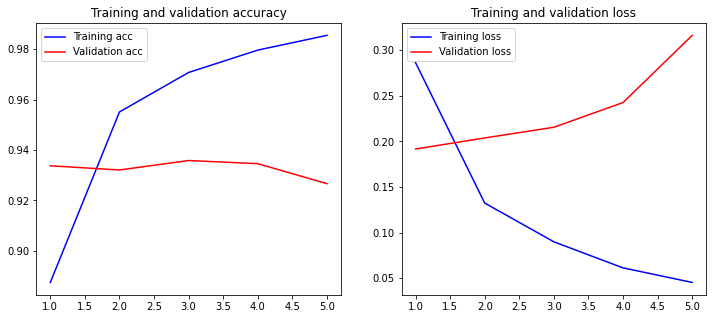

In [10]:
plot_history(history)

In [11]:
model.load_weights(checkpoint_filepath)

In [12]:
# results = model.predict_classes(test_data)
results = (model.predict(test_data) > 0.5).astype("int32")

In [13]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

In [14]:
f1 = (f1_score(test_labels_list,results ))*100
f1 = round(f1,2)
print('f1 score is: ',f1)

accuracy = (accuracy_score(test_labels_list,results ))*100
accuracy = round(accuracy,2)
print('accuracy score is: ',accuracy)

precision = (precision_score(test_labels_list,results ))*100
precision = round(precision,2)
print('precision score is: ',precision)

recall = (recall_score(test_labels_list,results ))*100
recall = round(recall,2)
print('recall score is: ',recall)

f1 score is:  93.77
accuracy score is:  93.58
precision score is:  91.12
recall score is:  96.58
